# TD 5 - La régression logistique - algo. de descente du gradient

## Packages utiles

In [17]:
from sklearn import datasets # donnees
import os # rep de travail
import pandas as pd # data analysis
from scipy import stats # stat desc
import matplotlib.pyplot as plt # graphiques
import numpy as np # maths
import sklearn.preprocessing # standardisation des donnees
from collections import Counter # freq table

from sklearn.linear_model import LogisticRegression    #Logistic Regression
from sklearn.model_selection import train_test_split # train and test samples
from sklearn.metrics import confusion_matrix # confusion matrix
from scipy import optimize # algos d'optim
from mpl_toolkits.mplot3d import Axes3D

## Les données

In [3]:
#-- Import des données
breast_cancer = datasets.load_breast_cancer()
print(breast_cancer.DESCR)
#Data Set Characteristics:
#    :Number of Instances: 569
#
#    :Number of Attributes: 30 numeric, predictive attributes and the class
#
#    :Attribute Information:
#        - radius (mean of distances from center to points on the perimeter)
#        - texture (standard deviation of gray-scale values)
#        - perimeter
#        - area
#        - smoothness (local variation in radius lengths)
#        - compactness (perimeter^2 / area - 1.0)
#        - concavity (severity of concave portions of the contour)
#        - concave points (number of concave portions of the contour)
#        - symmetry
#        - fractal dimension ("coastline approximation" - 1)
#
#        The mean, standard error, and "worst" or largest (mean of the three
#        largest values) of these features were computed for each image,
#        resulting in 30 features.  For instance, field 3 is Mean Radius, field
#        13 is Radius SE, field 23 is Worst Radius.
#
#        - class:
#                - WDBC-Malignant
#                - WDBC-Benign


.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [4]:
#-- Stat. descriptives
dat=breast_cancer.data
Y=breast_cancer.target
names = breast_cancer.feature_names
#%% Stat descriptives
df=pd.DataFrame(dat)
df.columns=names # pour ajouter les noms de colonnes
Counter(Y) # nb of cases / controls
df.groupby(Y).mean()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530
1,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442


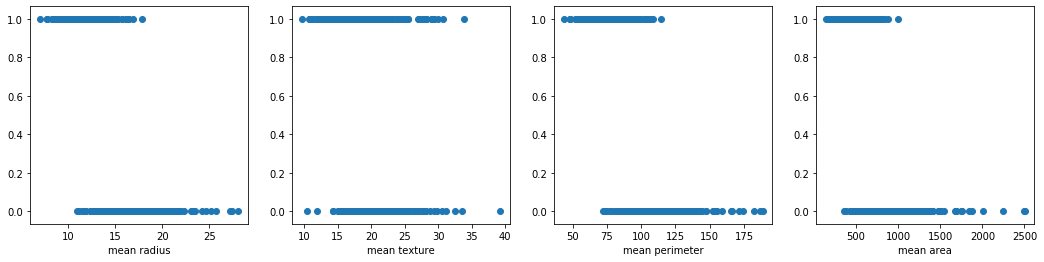

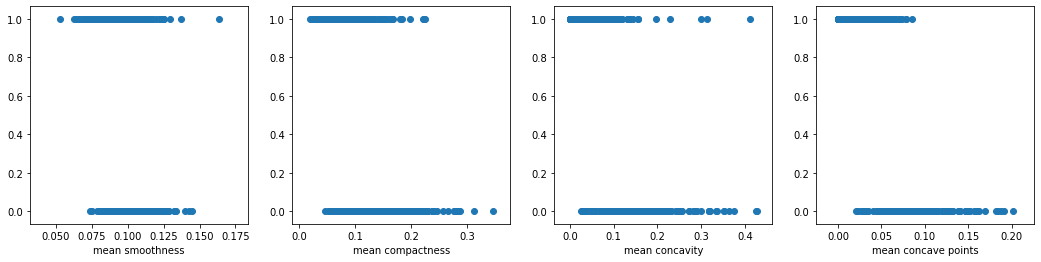

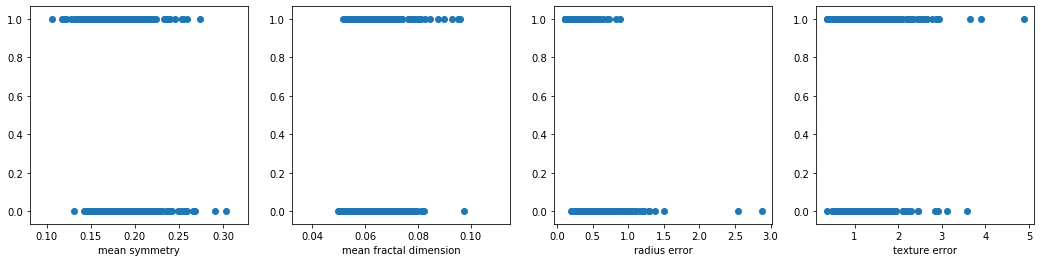

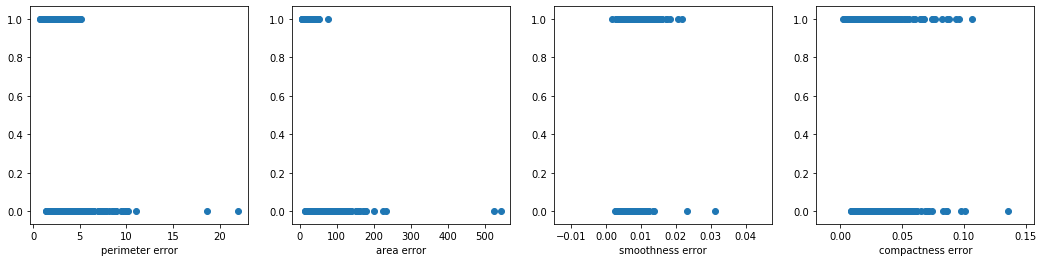

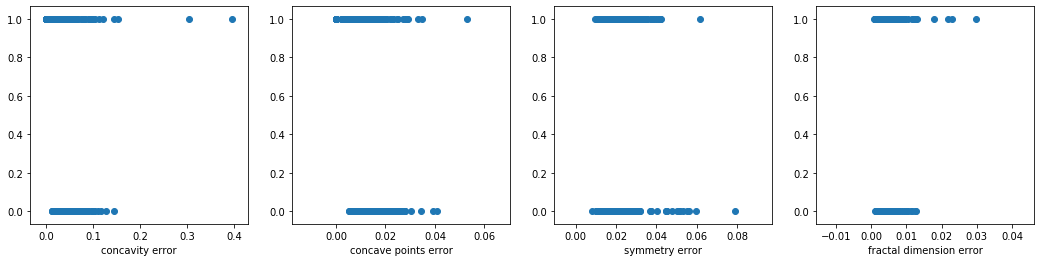

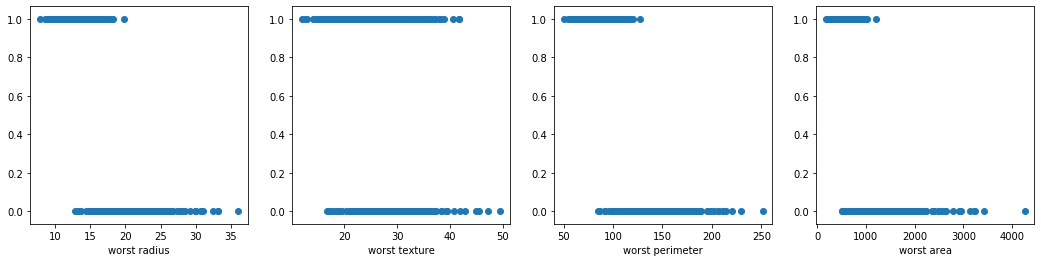

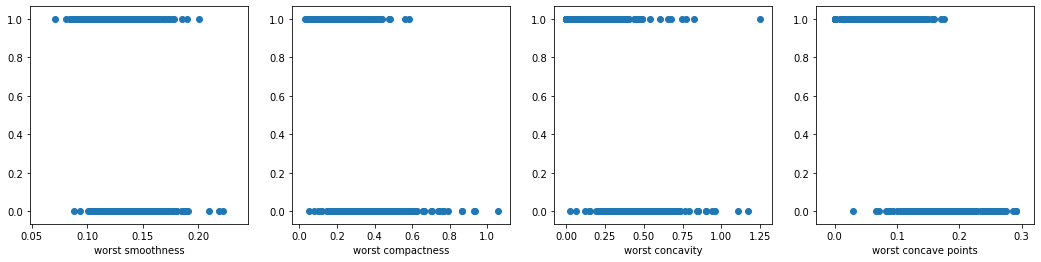

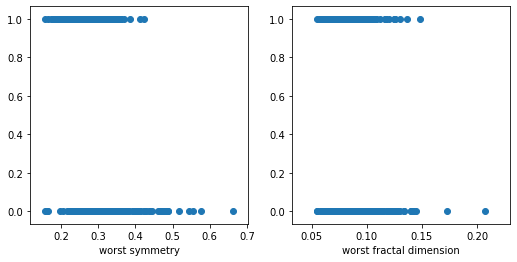

In [5]:
#-- Plots
for i in range(0,dat.shape[1],4):
    plt.figure(figsize=(18,4))
    for j in range(0,4):
        if i+j < dat.shape[1]:
            plt.subplot(1,4,j+1)
            plt.scatter(dat[:,i+j],Y)
            plt.xlabel(names[i+j])
    plt.show()

## Algo de descente du gradient pour la régression logistique

code des fonctions et tests de ces fonctions dans le cas de la régression logistique simple et multiple


In [6]:
k= 2 
k1 = 2
k2 = 3
X = np.hstack((np.ones((dat.shape[0],1)),dat))
X1 = np.hstack((np.reshape(X[:,0],(dat.shape[0],1)), np.reshape(X[:,k],(dat.shape[0],1))))
X2 = np.hstack((np.reshape(X[:,0],(dat.shape[0],1)), np.reshape(X[:,k1],(dat.shape[0],1)), np.reshape(X[:,k2],(dat.shape[0],1))))
print(X1)
print(X2)

[[ 1.   10.38]
 [ 1.   17.77]
 [ 1.   21.25]
 ...
 [ 1.   28.08]
 [ 1.   29.33]
 [ 1.   24.54]]
[[  1.    10.38 122.8 ]
 [  1.    17.77 132.9 ]
 [  1.    21.25 130.  ]
 ...
 [  1.    28.08 108.3 ]
 [  1.    29.33 140.1 ]
 [  1.    24.54  47.92]]


In [7]:
###### -- standardisation des X
def standardisation(x):
    x_data = x[:,1:]
    return np.hstack((x[:,:1],(x_data - x_data.mean(axis=0)) / x_data.std(axis=0,ddof=0)))

#-- Test 1 - reg simple
X1_standard = standardisation(X1)
print(stats.describe(X1_standard))
print(X1_standard)

#-- Test 2 - reg multiple
X2_standard = standardisation(X2)
print(X2_standard)

DescribeResult(nobs=569, minmax=(array([ 1.        , -2.22924851]), array([1.        , 4.65188898])), mean=array([1.00000000e+00, 1.04973636e-16]), variance=array([0.        , 1.00176056]), skewness=array([0.        , 0.64873357]), kurtosis=array([-3.        ,  0.74114542]))
[[ 1.         -2.07333501]
 [ 1.         -0.35363241]
 [ 1.          0.45618695]
 ...
 [ 1.          2.0455738 ]
 [ 1.          2.33645719]
 [ 1.          1.22179204]]
[[ 1.         -2.07333501  1.26993369]
 [ 1.         -0.35363241  1.68595471]
 [ 1.          0.45618695  1.56650313]
 ...
 [ 1.          2.0455738   0.67267578]
 [ 1.          2.33645719  1.98252415]
 [ 1.          1.22179204 -1.81438851]]


In [8]:
#-- Modèle
# attention X : contient X^0 = [1,...,1] + les X^j
def f(x,B):
    exb = np.exp(np.dot(x,B))
    return np.divide(exb,1+exb)

#-- Test 1 - reg simple
B1 = [2,3]
print(X1)
print(f(X1_standard,[0,0.2]))

#-- Test 2 - reg multiple
B2 = [2,3,4]
#print(f(X2_standard,B2))


[[ 1.   10.38]
 [ 1.   17.77]
 [ 1.   21.25]
 ...
 [ 1.   28.08]
 [ 1.   29.33]
 [ 1.   24.54]]
[0.39779359 0.48232575 0.52279354 0.51268388 0.44266252 0.45833011
 0.50803178 0.51791483 0.52940751 0.55504789 0.54583463 0.48372038
 0.56376568 0.55401316 0.5385567  0.59483326 0.50977653 0.51617156
 0.53323209 0.44289218 0.45844566 0.42097021 0.44174413 0.54352615
 0.52430278 0.46642856 0.52604365 0.51117215 0.56913763 0.4508297
 0.56731064 0.49313967 0.55435813 0.58277686 0.48360415 0.52673983
 0.52824784 0.48988273 0.56833855 0.51779863 0.5266238  0.52395453
 0.56388013 0.51152103 0.52929156 0.4803505  0.47152835 0.49267435
 0.44599492 0.53496927 0.52685584 0.46573365 0.48778942 0.49313967
 0.53172588 0.49372134 0.49162743 0.52673983 0.5002368  0.41361434
 0.44887159 0.51965767 0.53323209 0.43715828 0.55274787 0.55389817
 0.52000618 0.49709529 0.47721462 0.46747116 0.52349016 0.44610992
 0.56055815 0.4593702  0.46781876 0.50419271 0.40405344 0.463534
 0.55424314 0.48499901 0.51954149 0.

In [9]:
#-- Fonction-cout
# ordre des arguments : beta en 1er pour comparer avec la fonction d'optim
def cout(B,x,y):
    fB = f(x,B)
    return -1/x.shape[0] * (np.dot(y,np.log(fB)) + np.dot(1-y,np.log(1-fB)))

#%% Test 1 - reg simple
print(cout([1,1],X1_standard,Y))
#%% Test 2 - reg multiple
print(cout(B2,X2_standard,Y))


0.9738532957118856
4.208726878326237


In [10]:
#-- Gradient
# ordre des arguments : beta en 1er pour comparer avec la fonction d'optim
def grad(B,x,y):
    return 1/x.shape[0] * np.dot((f(x,B)-y),x)

#%% Test 1 - reg simple
print(grad([1,1],X1_standard,Y))

#%% Test 2 - reg multiple
print(grad(B2,X2_standard,Y))

[0.0666003  0.36447474]
[-0.06182767  0.49539301  0.65301784]


In [11]:
#-- Algo de descente du gradient
def grad_descent(init,x,y,pas,epsi,ITE_MAX):
    nbIt = 0
    x_normalize = standardisation(x)
    cout_arr = []
    b_arr = []
    B = np.asarray(init).astype(float)
    new_B = B.copy()
    b_arr.append(B.tolist())
    old_cout = 0
    new_cout = cout(B,x_normalize,y)
    cout_arr.append(new_cout)
    while(np.abs(new_cout-old_cout)>epsi and nbIt < ITE_MAX):
        new_B = B - pas * grad(B,x_normalize,y)
        B = new_B.copy()
        old_cout = new_cout
        new_cout = cout(B,x_normalize,y)
        b_arr.append(B.tolist())
        cout_arr.append(new_cout)
        nbIt += 1
    return b_arr,cout_arr

#-- Test 1  - reg simple
b, c = grad_descent((0,0.2),X1,Y,0.05,0.01,500)
print("b",b)
print("c",c)
#-- Test 2 - reg multiple
print()
b, c = grad_descent((0,0,0),X2,Y,0.05,0.01,500)
print(b)
print(c)

b [[0.0, 0.2], [0.006375985168497839, 0.18749318218632108]]
c [0.7382645091114638, 0.7343470742956743]

[[0.0, 0.0, 0.0], [0.0063708260105448155, -0.010036949633874742, -0.01795293670311326]]
[0.6931471805599446, 0.6839472611673111]


In [27]:
from scipy.special import expit

def displayCout(data_c,title):
    plt.figure(1,figsize=(10,6))
    plt.grid()
    plt.title("Evolution du cout "+title)
    x = np.linspace(0, len(data_c), len(data_c))
    plt.plot(x, data_c)
    plt.xlabel("Nb iterations")
    plt.ylabel("Cout")
    plt.show()
    
def display(title,data_X,data_Y,data_b,data_c=None):
    print("\nBetas :",data_b[-1])
    plt.figure(1,figsize=(10,6))
    plt.title(title)
    plt.scatter(standardisation(data_X)[:,1],data_Y)
    x_lim = plt.xlim()
    x = np.linspace(x_lim[0],x_lim[1],100)
    y = expit(x*data_b[0][0]+data_b[0][1])
    plt.plot(x,y,color='green')
    for i in range(1,len(data_b)-1,10): 
        y = expit(x*data_b[i][0]+data_b[i][1])
        plt.plot(x,y,color='gray')
    y = expit(x*data_b[-1][0]+data_b[-1][1])
    plt.plot(x,y,color='red')
    plt.xlabel(names[k-1])
    plt.ylabel("Breast Cancer")
    plt.show()
    if data_c != None:
        displayCout(data_c,"regression logistique simple")
        
def display3D(title,data_X,data_Y,data_b,data_c=None):
    print("\nBetas :",data_b[-1])
    fig = plt.figure(1,figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    xx = standardisation(data_X)
    ax.scatter(xx[:,1],xx[:,2],data_Y,c='r', marker='o')
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    x = np.arange(x_lim[0], x_lim[1], 0.05)
    y = np.arange(y_lim[0], y_lim[1], 0.05)
    x, y = np.meshgrid(x, y)
    z = expit(x*data_b[-1][0]+data_b[-1][1]*y+data_b[-1][2])
    z = z.reshape(x.shape)
    ax.plot_wireframe(x,y,z,color='gray')
    ax.set_xlabel(names[k1-1])
    ax.set_ylabel(names[k2-1])
    ax.set_zlabel("Breast Cancer")
    plt.show()
    if data_c != None:
        displayCout(data_c,"regression lineaire multiple")

## Test avec plusieurs initialisations 
visualisation de la fonction cout et des valeurs des paramètres au cours des itérations


Betas : [0.5992537239557103, -1.00733204188107]


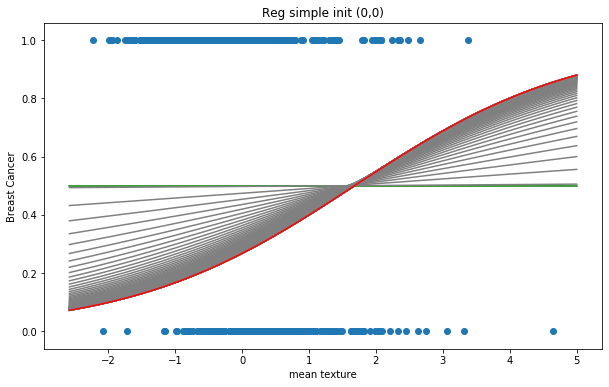

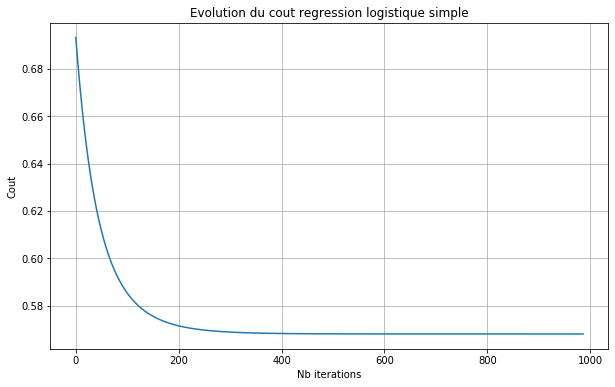


Betas : [0.5992591490200806, -1.0073313109521806]


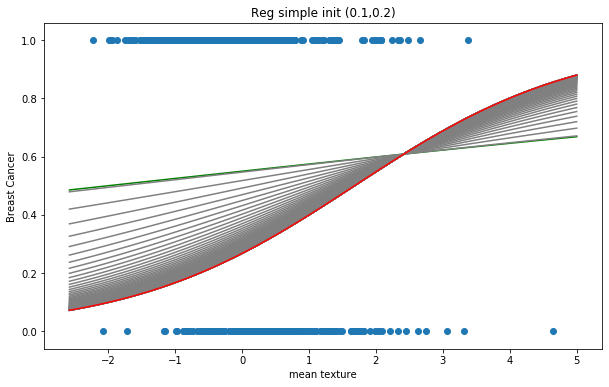

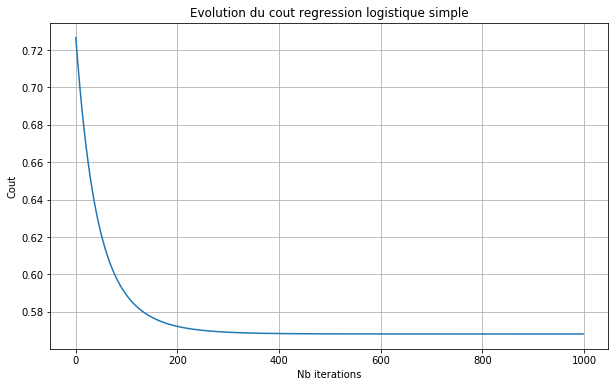


Betas : [0.5992802919220761, -1.0073227990860303]


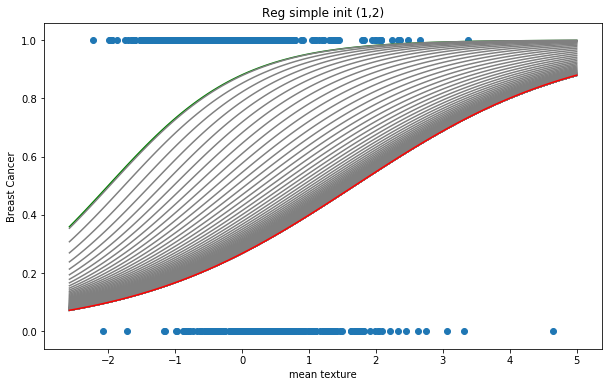

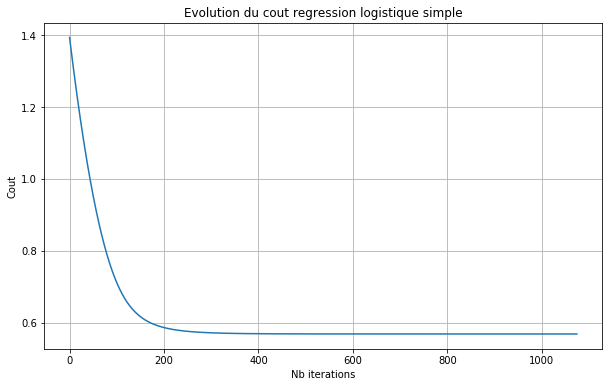


Betas : [0.6989425278488138, -0.9541363368593714, -4.0598881070996224]


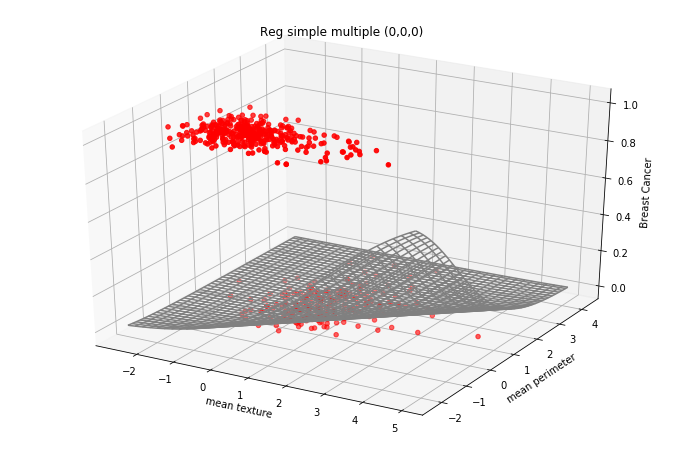

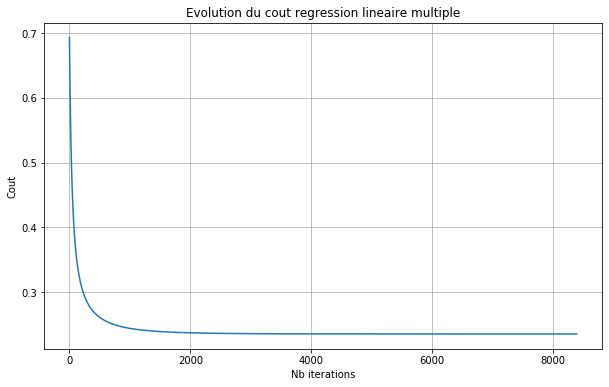


Betas : [0.6989424621807573, -0.9541358629868639, -4.059884574690401]


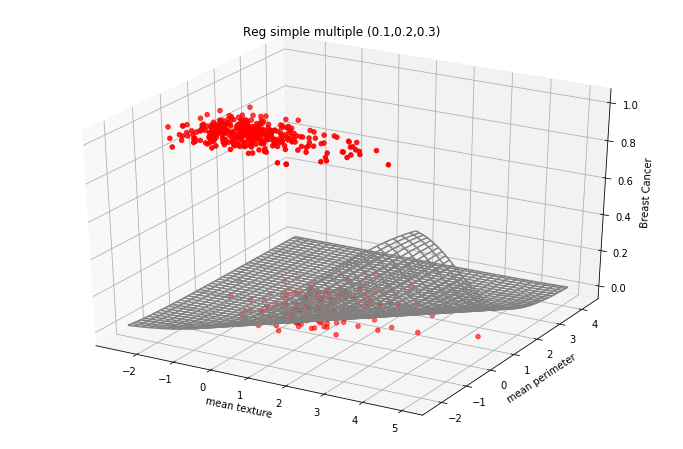

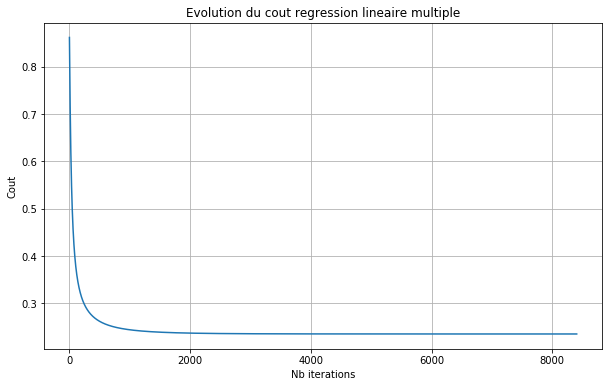


Betas : [0.6989425308767911, -0.9541363587083905, -4.059888269967913]


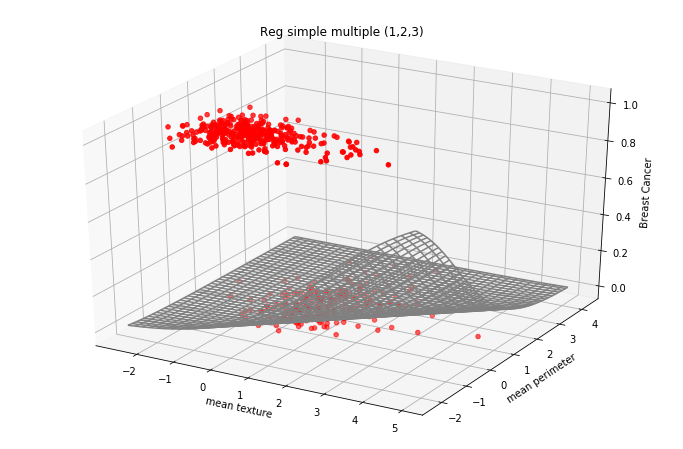

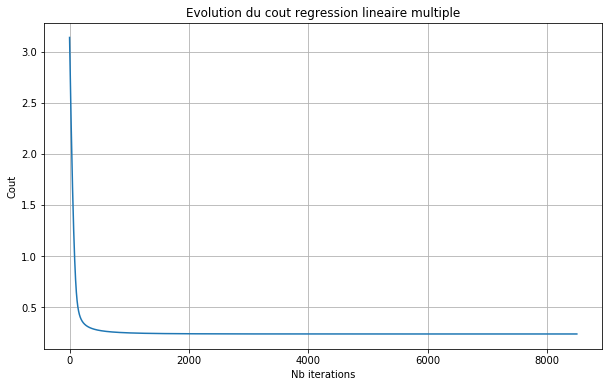

In [40]:
#-- Test 1  - reg simple

# init 1
b, c = grad_descent((0,0),X1,Y,0.05,1e-9,10000)
display("Reg simple init (0,0)",X1,Y,b,c)
# init 2
b, c = grad_descent((0.1,0.2),X1,Y,0.05,1e-9,10000)
display("Reg simple init (0.1,0.2)",X1,Y,b,c)
# init 3
b, c = grad_descent((1,2),X1,Y,0.05,1e-9,10000)
display("Reg simple init (1,2)",X1,Y,b,c)


#-- Test 2 - reg multiple

# init 1
b, c = grad_descent((0,0,0),X2,Y,0.05,1e-9,10000)
display3D("Reg simple multiple (0,0,0)",X2,Y,b,c)
# init 2
b, c = grad_descent((0.,0.2,0.3),X2,Y,0.05,1e-9,10000)
display3D("Reg simple multiple (0.1,0.2,0.3)",X2,Y,b,c)
# init 3
b, c = grad_descent((1,2,3),X2,Y,0.05,1e-9,10000)
display3D("Reg simple multiple (1,2,3)",X2,Y,b,c)
# ...






COMMENTAIRES: 

## Test avec plusieurs pas de descente
visualisation de la fonction cout et des valeurs des paramètres au cours des itérations


Betas : [0.598764216749767, -1.0061103311541422]


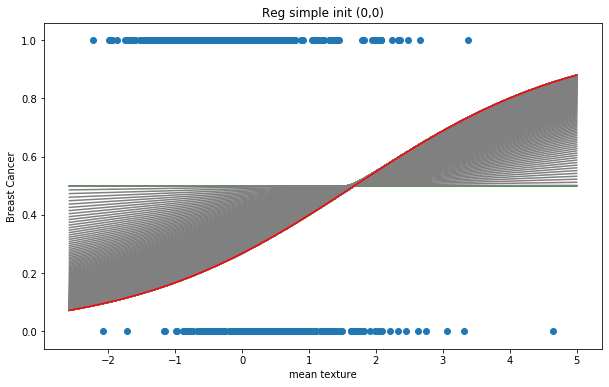

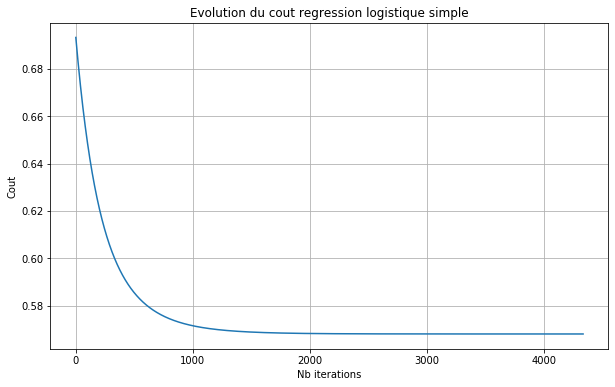


Betas : [0.5993690590887206, -1.0076230354805487]


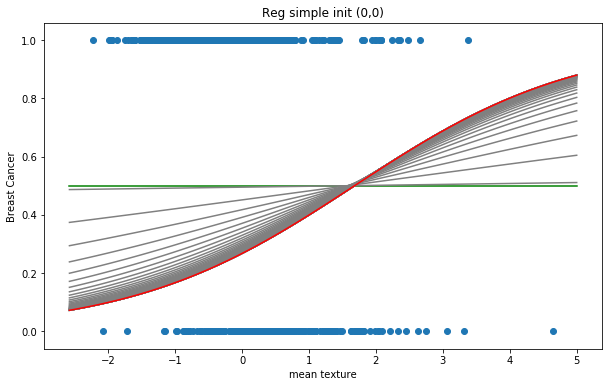

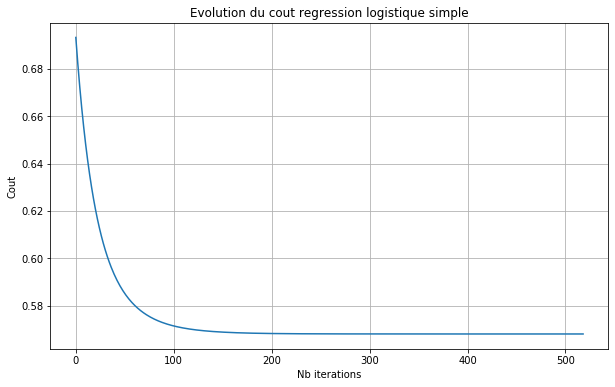


Betas : [0.5005575666338329, -0.8111876631169949]


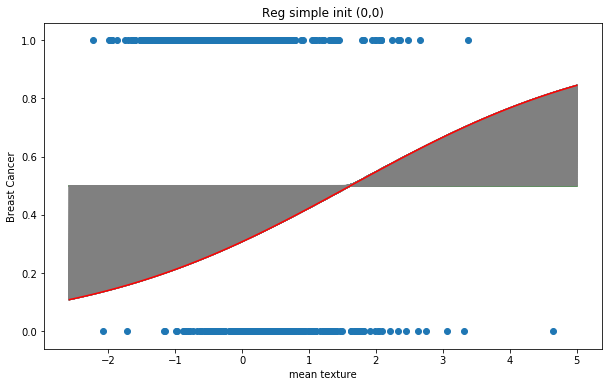

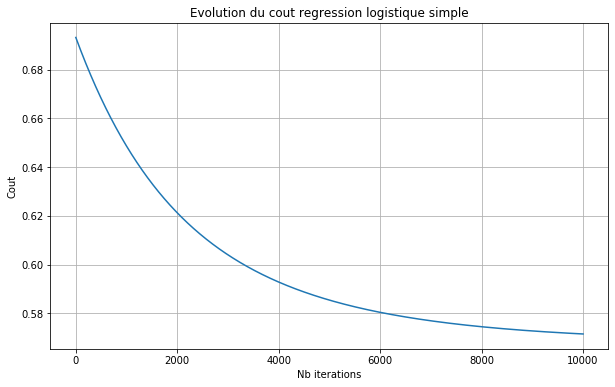


Betas : [0.6905152452121541, -0.8877601122655197, -3.545827201531127]


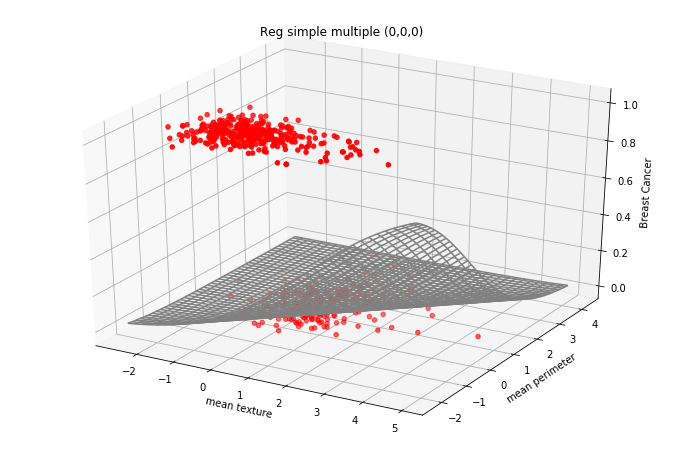

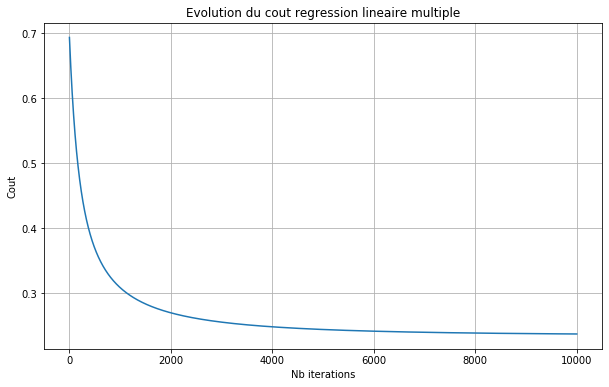


Betas : [0.6990100419013534, -0.9546231429615133, -4.063516069080992]


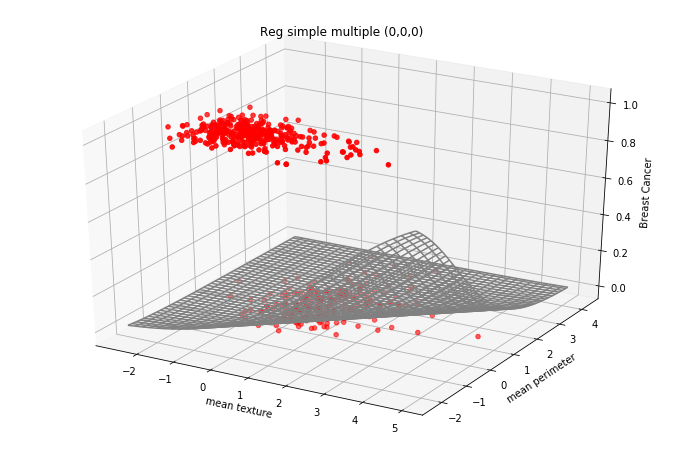

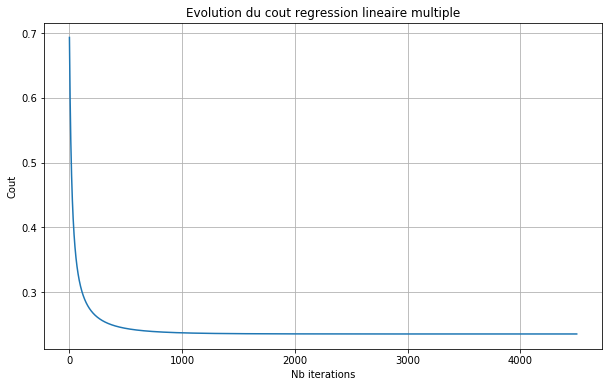


Betas : [0.5155098222900298, -0.6096412343092106, -1.552996892159287]


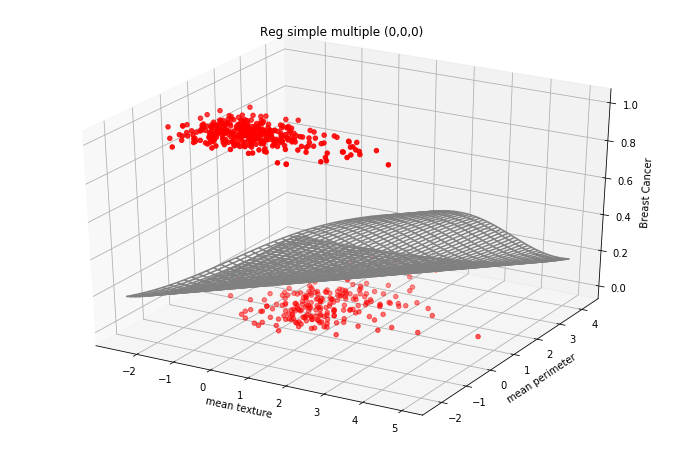

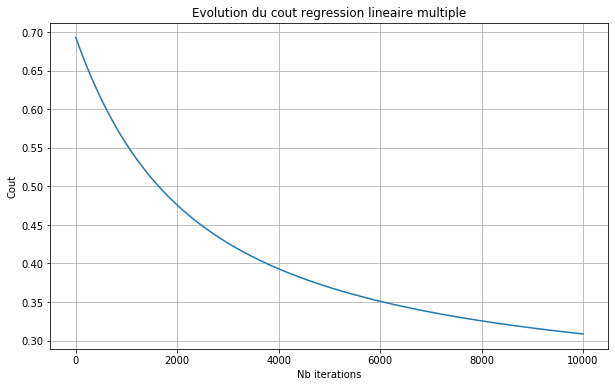

In [41]:
#-- Test 1  - reg simple

# alpha 1
b, c = grad_descent((0,0),X1,Y,0.01,1e-9,10000)
display("Reg simple init (0,0)",X1,Y,b,c)
# alpha 2
b, c = grad_descent((0,0),X1,Y,0.1,1e-9,10000)
display("Reg simple init (0,0)",X1,Y,b,c)
# alpha 3
b, c = grad_descent((0,0),X1,Y,0.001,1e-9,10000)
display("Reg simple init (0,0)",X1,Y,b,c)
# ...



#-- Test 2 - reg multiple

# alpha 1
# init 1
b, c = grad_descent((0,0,0),X2,Y,0.01,1e-9,10000)
display3D("Reg simple multiple (0,0,0)",X2,Y,b,c)
# alpha 2
# init 1
b, c = grad_descent((0,0,0),X2,Y,0.1,1e-9,10000)
display3D("Reg simple multiple (0,0,0)",X2,Y,b,c)
# alpha 3
# init 1
b, c = grad_descent((0,0,0),X2,Y,0.001,1e-9,10000)
display3D("Reg simple multiple (0,0,0)",X2,Y,b,c)
# ...


COMMENTAIRES:


Betas : [ 2.56288528 -0.23464048]


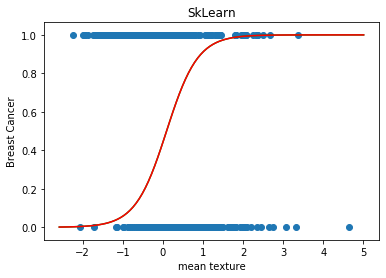


Betas : [10.20811294 -0.22241944 -0.16773756]


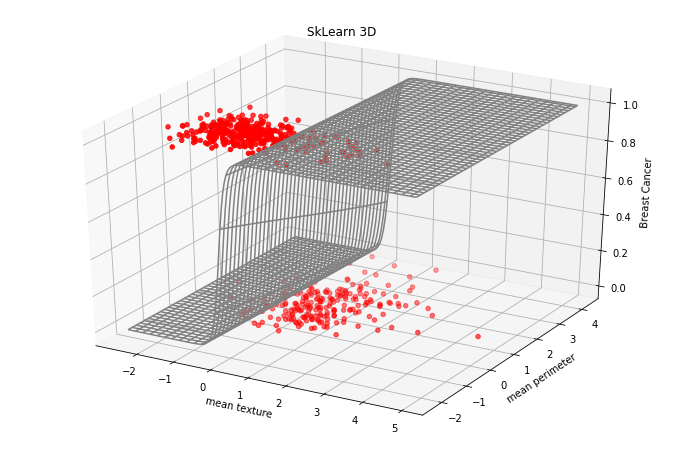

C:\Users\Megaport\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Megaport\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Optimization terminated successfully.
         Current function value: 0.568119
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 21

Betas : [ 5.12577241 -0.23464058]


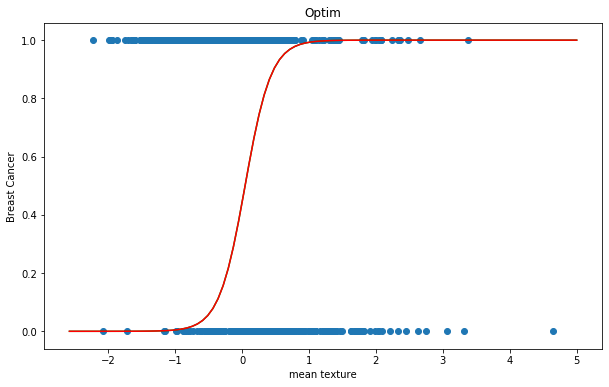

C:\Users\Megaport\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Optimization terminated successfully.
         Current function value: 0.235570
         Iterations: 26
         Function evaluations: 33
         Gradient evaluations: 33

Betas : [20.41639512 -0.22242174 -0.16773889]


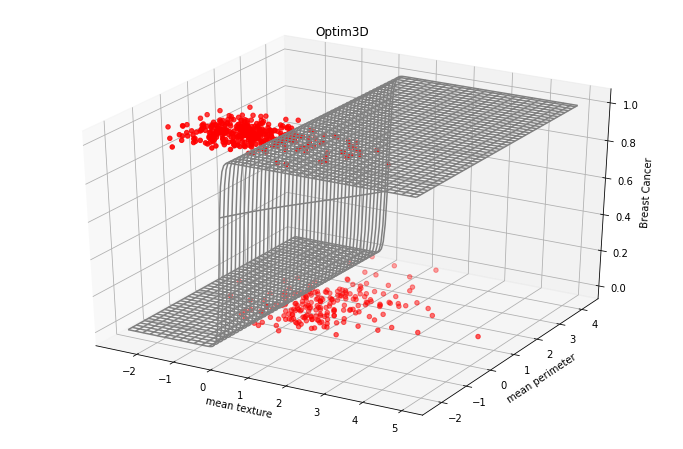

In [46]:
#-- Pour comparer
clf = LogisticRegression(C=1e5, solver='lbfgs')
clf.fit(X1, Y)

clf3D = LogisticRegression(C=1e5, solver='lbfgs')
clf3D.fit(X2, Y)
# and plot the result
plt.clf()
display("SkLearn",X1,Y,clf.coef_)
display3D("SkLearn 3D",X2,Y,clf3D.coef_)
# avec les algos d'optim
opti = optimize.fmin_bfgs(cout, x0 = [0,0], fprime = grad, args = (X1, Y), gtol = 1e-9)
display("Optim",X1,Y,[opti])
opti3D = optimize.fmin_bfgs(cout, x0 = [0,0,0], fprime = grad, args = (X2, Y), gtol = 1e-9)
display3D("Optim3D",X2,Y,[opti3D])

COMMENTAIRES: 

On observe une grande différence entre ma régression logistique et celle de sklearn. Cela est due au fait que sklearn effectue beaucoup d'optimisation sur les betas. On le voit bien quand on utilise optimize sur mes fonctions, le résultat est plus cohérent.